<a href="https://colab.research.google.com/github/sunRise9551/Building_Makemore/blob/main/Makemore_with_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [15]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [14]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [18]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [19]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

# Embedding

## Understand How embedding works

- Create an embedding matrix
- In our case, we have 27 characters in total, and we want to embed into 2 dimensions
- Therefore, we will have a Matrix (27 x 2)


In [20]:
C = torch.randn((27, 2))
C

tensor([[-4.0818e-01,  1.1019e-02],
        [ 1.5594e+00, -1.2483e+00],
        [ 1.5466e-01,  4.9418e-01],
        [ 6.8956e-01,  4.6290e-01],
        [ 3.4362e-01,  7.1958e-01],
        [ 7.7663e-01, -7.8807e-01],
        [-2.9161e-02, -1.5856e+00],
        [ 1.9109e-01, -1.3325e-01],
        [-3.6263e-01,  1.7756e-01],
        [-7.4985e-01, -1.3316e+00],
        [ 3.2058e-04, -1.6475e+00],
        [ 4.6201e-01,  3.8196e-01],
        [ 1.7899e-01, -1.5569e-02],
        [ 1.2369e-01,  1.3112e+00],
        [-1.0826e+00, -5.8774e-01],
        [-2.1071e+00, -1.1993e+00],
        [ 5.7197e-01,  4.8596e-01],
        [ 5.1327e-01,  3.0276e+00],
        [ 2.9422e-01, -1.9897e-01],
        [-2.6189e+00, -1.4548e+00],
        [ 9.2228e-02, -7.5863e-02],
        [-5.3189e-01,  2.5664e+00],
        [ 6.3986e-01, -3.4608e-01],
        [-5.7797e-01, -1.4902e+00],
        [-7.3708e-01,  1.0979e+00],
        [-2.0297e-01, -4.5364e-01],
        [-2.0941e+00,  2.7183e-01]])

## How to Embed ?

### Solution 1

Let's say we want to embed integer 5

In [21]:
C[5]

tensor([ 0.7766, -0.7881])

### Solution 2

Recall from our Makemore_with_Bigram while using One-hot encoding

1. Let's say we want to One-hot encode integer 5 with 27 classes
2. We then multiply by Matrix C

There are identical

In [25]:
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [23]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.7766, -0.7881])

Integer indexing into lookup table C

As a first layer of the neural net, this layer here has neurons that have no non-linearity, just linear neurons, and their weights matrix is C, and we are encoding integers into One-hot and feeding them to the neural net. And the first layer basically embeds them.

## How to Embed Simultaneously ?

In PyTorch, we can:

In [26]:
C[5]

tensor([ 0.7766, -0.7881])

In [28]:
C[[5,6,7,8,9,10]]

tensor([[ 7.7663e-01, -7.8807e-01],
        [-2.9161e-02, -1.5856e+00],
        [ 1.9109e-01, -1.3325e-01],
        [-3.6263e-01,  1.7756e-01],
        [-7.4985e-01, -1.3316e+00],
        [ 3.2058e-04, -1.6475e+00]])

In [29]:
C[[5,6,6,6,6,6,6,7,8,9,10]]

tensor([[ 7.7663e-01, -7.8807e-01],
        [-2.9161e-02, -1.5856e+00],
        [-2.9161e-02, -1.5856e+00],
        [-2.9161e-02, -1.5856e+00],
        [-2.9161e-02, -1.5856e+00],
        [-2.9161e-02, -1.5856e+00],
        [-2.9161e-02, -1.5856e+00],
        [ 1.9109e-01, -1.3325e-01],
        [-3.6263e-01,  1.7756e-01],
        [-7.4985e-01, -1.3316e+00],
        [ 3.2058e-04, -1.6475e+00]])

So, we can simply just do C[X]

In [32]:
emb = C[X]
emb

tensor([[[-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [-0.4082,  0.0110]],

        [[-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [ 0.7766, -0.7881]],

        [[-0.4082,  0.0110],
         [ 0.7766, -0.7881],
         [ 0.1237,  1.3112]],

        [[ 0.7766, -0.7881],
         [ 0.1237,  1.3112],
         [ 0.1237,  1.3112]],

        [[ 0.1237,  1.3112],
         [ 0.1237,  1.3112],
         [ 1.5594, -1.2483]],

        [[-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [-0.4082,  0.0110]],

        [[-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [-2.1071, -1.1993]],

        [[-0.4082,  0.0110],
         [-2.1071, -1.1993],
         [ 0.1790, -0.0156]],

        [[-2.1071, -1.1993],
         [ 0.1790, -0.0156],
         [-0.7498, -1.3316]],

        [[ 0.1790, -0.0156],
         [-0.7498, -1.3316],
         [ 0.6399, -0.3461]],

        [[-0.7498, -1.3316],
         [ 0.6399, -0.3461],
         [-0.7498, -1.3316]],

        [[ 0.6399, -0

In [33]:
emb.shape

torch.Size([32, 3, 2])

### Why is this working ?

Remember our X, is currently the Inputs, that is 32 x 3

32 represents the number

3 represents the correspond character in integer

In [43]:
X.shape

torch.Size([32, 3])

In [41]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

Let's take X[2, 2], gives us integer 13

In [46]:
X[2, 2]

tensor(13)

Let's take C[X] and then we indexing by X[2,2]

We get the embedding.

In [47]:
C[X][2,2]

tensor([0.1237, 1.3112])

Let's verify by indexing C in [13]

In [48]:
C[13]

tensor([0.1237, 1.3112])

Long Story Short, PyTorch Indexing is AWESOME!

# Implement Hidden Layer

## Concept

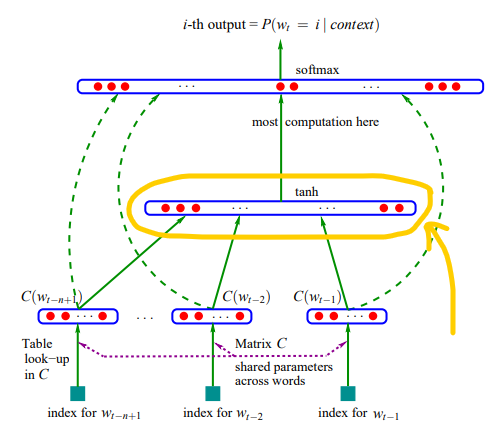

We have our inputs from block (32, 3, 2), we have 3 blocks of this, resulting inputs of 6
  - 32: Characters
  - 3: Input
  - 2: Dimensions
  - Output = Input * Dimensions = 3 * 2 = 6

We have our outputs (Hyperparamter), we choose 100 here.

Let's define our parameters

In [60]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

Normally, we will then multiply them together:

- We cannot do it here, because dimensions doesn't match
- We will need to

In [61]:
emb @ W1 + b1

RuntimeError: ignored

## Solution

In [50]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

This code simply means that we take these 3 blocks, and concatenate them by their 2nd dimension, which is index 1

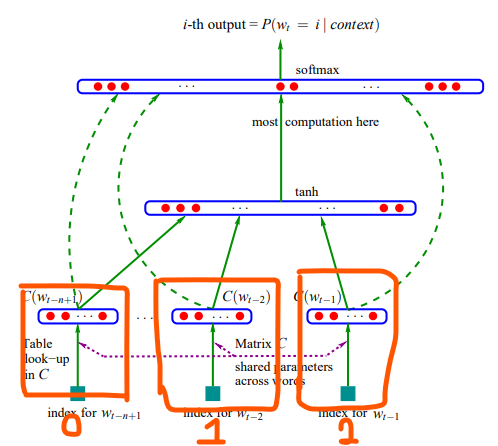

But this is not Generalize, error occurs if our block size changes

## Generalize

We will need to use "unbind"

In [53]:
emb.shape

torch.Size([32, 3, 2])

We unbind the 2nd dimension, which is index 1

In [52]:
torch.unbind(emb, 1)

(tensor([[-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [ 0.7766, -0.7881],
         [ 0.1237,  1.3112],
         [-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [-2.1071, -1.1993],
         [ 0.1790, -0.0156],
         [-0.7498, -1.3316],
         [ 0.6399, -0.3461],
         [-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [ 1.5594, -1.2483],
         [-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [-0.7498, -1.3316],
         [-2.6189, -1.4548],
         [ 1.5594, -1.2483],
         [ 0.1547,  0.4942],
         [ 0.7766, -0.7881],
         [ 0.1790, -0.0156],
         [-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [-2.6189, -1.4548],
         [-2.1071, -1.1993],
         [ 0.5720,  0.4860],
         [-0.3626,  0.1776]]),
 tensor([[-0.4082,  0.0110],
         [-0.4082,  0.0110],
         [ 0

Both are equivalent:
- torch.unbind(emb, 1)
- [emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]]

Let's concatenate now

In [54]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

## Further Optimize

Because concatenate is waste of storage, further reading

Use "view"

In [56]:
emb.view(32, 6)

tensor([[-0.4082,  0.0110, -0.4082,  0.0110, -0.4082,  0.0110],
        [-0.4082,  0.0110, -0.4082,  0.0110,  0.7766, -0.7881],
        [-0.4082,  0.0110,  0.7766, -0.7881,  0.1237,  1.3112],
        [ 0.7766, -0.7881,  0.1237,  1.3112,  0.1237,  1.3112],
        [ 0.1237,  1.3112,  0.1237,  1.3112,  1.5594, -1.2483],
        [-0.4082,  0.0110, -0.4082,  0.0110, -0.4082,  0.0110],
        [-0.4082,  0.0110, -0.4082,  0.0110, -2.1071, -1.1993],
        [-0.4082,  0.0110, -2.1071, -1.1993,  0.1790, -0.0156],
        [-2.1071, -1.1993,  0.1790, -0.0156, -0.7498, -1.3316],
        [ 0.1790, -0.0156, -0.7498, -1.3316,  0.6399, -0.3461],
        [-0.7498, -1.3316,  0.6399, -0.3461, -0.7498, -1.3316],
        [ 0.6399, -0.3461, -0.7498, -1.3316,  1.5594, -1.2483],
        [-0.4082,  0.0110, -0.4082,  0.0110, -0.4082,  0.0110],
        [-0.4082,  0.0110, -0.4082,  0.0110,  1.5594, -1.2483],
        [-0.4082,  0.0110,  1.5594, -1.2483,  0.6399, -0.3461],
        [ 1.5594, -1.2483,  0.6399, -0.3

Verify

In [57]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

Back to our concept of multiplying

In [62]:
# emb @ W1 + b1
h = emb.view(32, 6) @ W1 + b1

Add a Tanh

In [63]:
h = torch.tanh(emb.view(32, 6) @ W1 + b1)

To not Hard code the block

In [65]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

# Implement SoftMax